# Amazon Reviews- Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk


In [2]:
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TEST\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
STOPWORDS=set(stopwords.words('english'))

In [4]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

In [5]:
!pip install wordcloud

In [6]:
from wordcloud import WordCloud

**Exploratory Data Analysis**

In [7]:
data=pd.read_csv(r"amazon_alexa.tsv", delimiter='\t', quoting=3)
data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1


In [8]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [10]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [12]:
data.shape

(3150, 5)

In [13]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [14]:
data.dropna(inplace=True)

In [15]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [16]:
data.shape

(3149, 5)

In [17]:
print(data.columns.values)

['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [18]:
data.iloc[10]['verified_reviews']#10th record

'"I sent it to my 85 year old Dad, and he talks to it constantly."'

In [19]:
data['length']=data['verified_reviews'].apply(len)#Length of the verified_reviews for Analysis

In [20]:
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


**Analyzing 'rating' column**

In [21]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

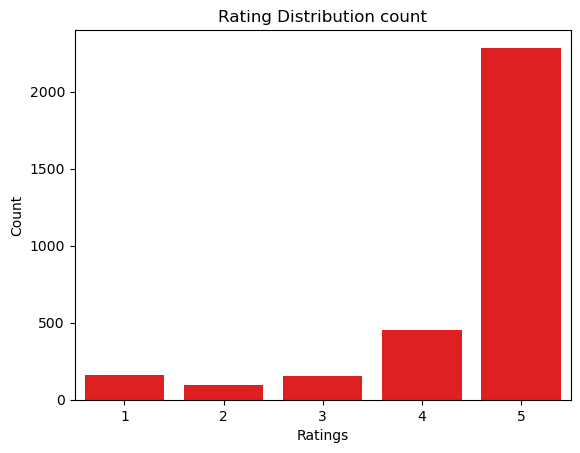

In [22]:
sns.countplot(x='rating',data=data,color='red',)
plt.title('Rating Distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [23]:
print("Rating value count - percentage distribution",round(data['rating'].value_counts()/data.shape[0]*100,2))


Rating value count - percentage distribution rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


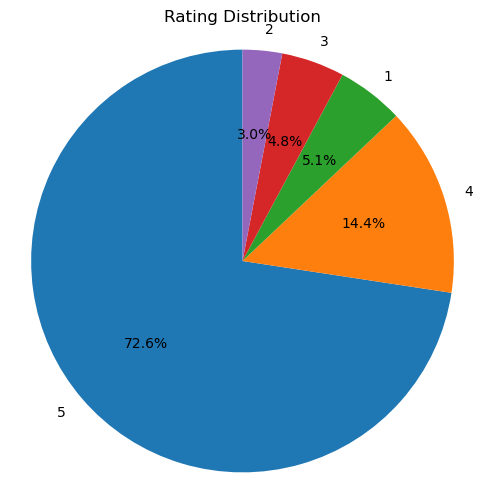

In [24]:
rating_counts = data['rating'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    rating_counts.values,
    labels=rating_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Rating Distribution')
plt.axis('equal')  # makes the pie a circle
plt.show()


**Analysing 'feedback' column**

In [25]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

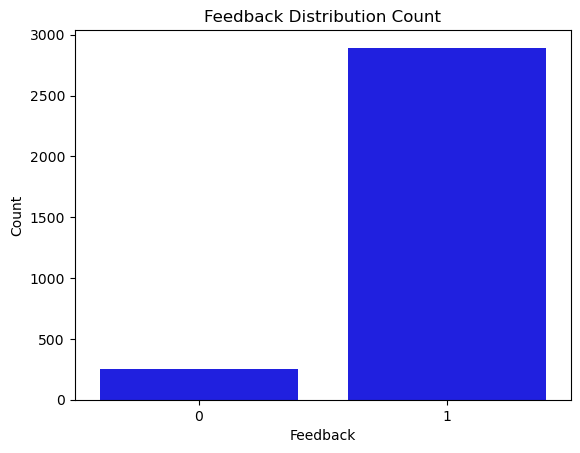

In [26]:
sns.countplot(x='feedback',data=data,color='blue')
plt.title("Feedback Distribution Count")
plt.xlabel("Feedback")
plt.ylabel("Count")
plt.show()

In [27]:
round(data['feedback'].value_counts()/data.shape[0]*100,2)

feedback
1    91.87
0     8.13
Name: count, dtype: float64

Feedback distribution

- 91.87% reviews are positive
- 8.13% reviews are negative

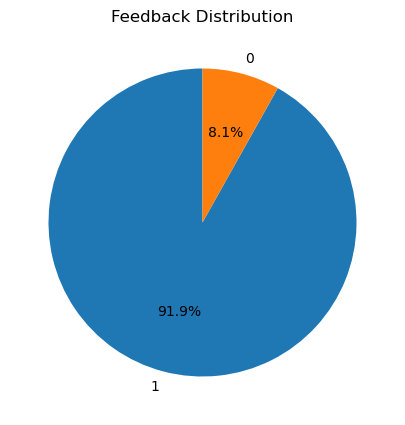

In [28]:
feedback_counts=data['feedback'].value_counts()
plt.figure(figsize=(6,5))
plt.pie(
    feedback_counts.values,
    labels=feedback_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Feedback Distribution')
plt.show()
    

In [29]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [30]:
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

- If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

**Analyzing 'variation' column**

In [31]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

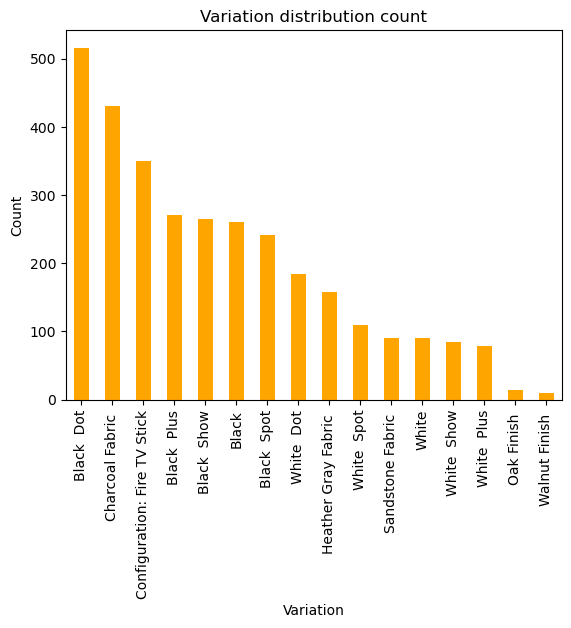

In [32]:
data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [33]:
round(data['variation'].value_counts()/data.shape[0]*100,2)

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

In [34]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

**Analyzing 'verified_reviews' column**

In [35]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Text(0.5, 1.0, 'Distribution of length of review')

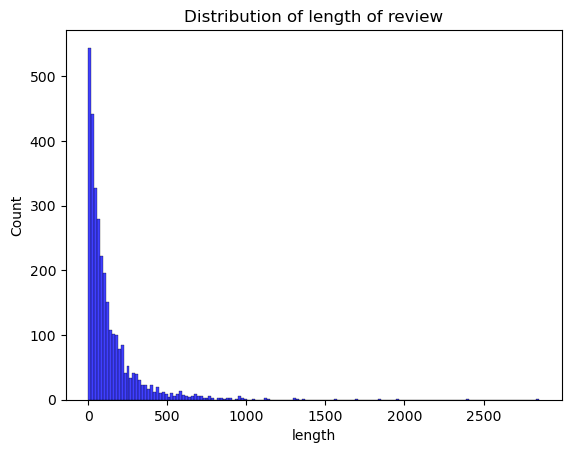

In [36]:
sns.histplot(data['length'],color='blue')
plt.title("Distribution of length of review")

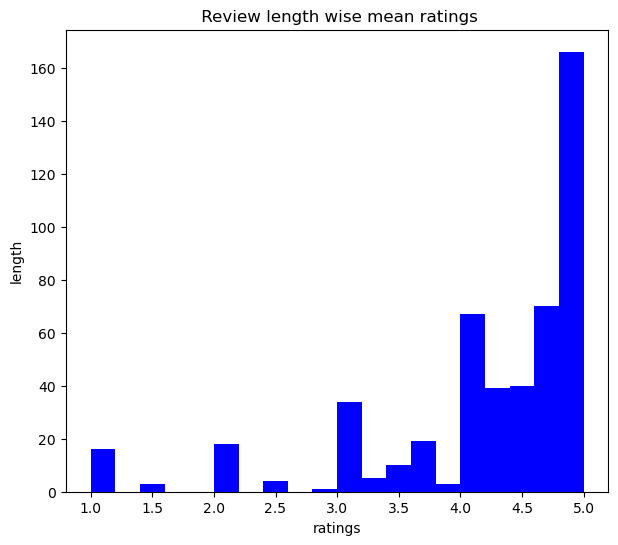

In [37]:
#Lengthwise mean rating

data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [38]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(data.verified_reviews)

In [39]:
#combinw all reviews
reviews=" ".join([review for review in data['verified_reviews']])

#Initializtion of wordcloud object
wc=WordCloud(background_color='white',max_words=50)

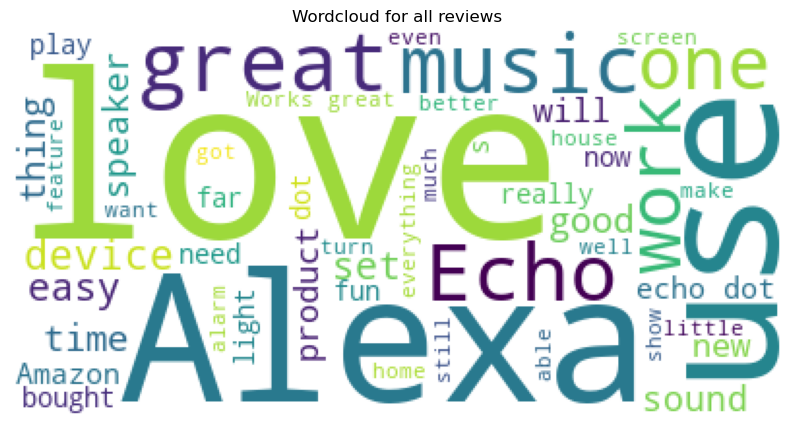

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews')
plt.axis('off')
plt.show()

In [41]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

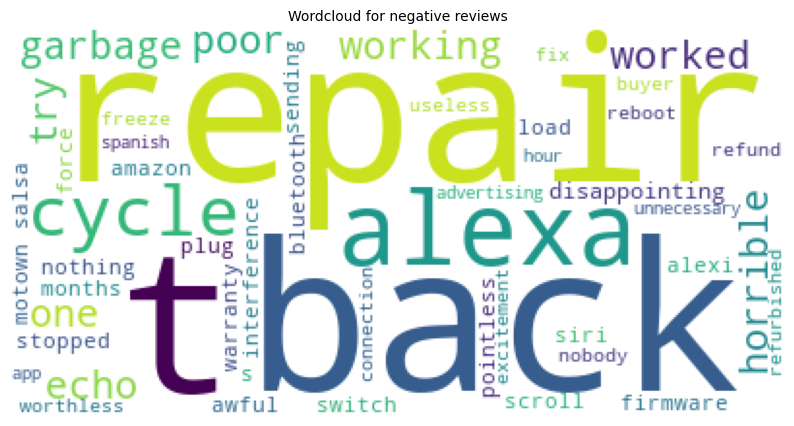

In [42]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

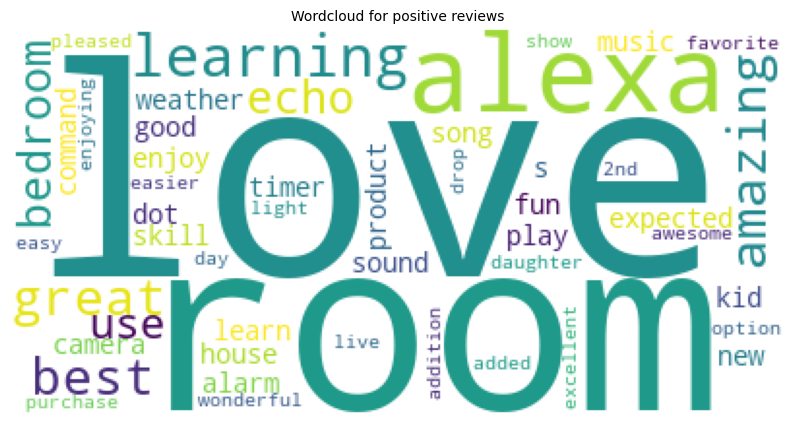

In [43]:

wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

**Preprocessing And Modelling**

In [44]:
#building the corpus from the 'verified_reviews'
corpus=[]
stemmer=PorterStemmer()

In [45]:
for i in range(0,data.shape[0]):
    review=re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
    review=review.lower().split()
    review=[stemmer.stem(word) for word in review if word not in STOPWORDS]
    review=' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [46]:
cv=CountVectorizer(max_features=2500)

In [47]:
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [48]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [49]:
X.shape,y.shape

((3149, 2500), (3149,))

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=15)

In [51]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2204, 2500), (945, 2500), (2204,), (945,))

In [52]:
X_train.max(),X_test.max()

(np.int64(12), np.int64(10))


Scaling X_train and X_test so that all values are between 0 and 1.

In [53]:
scaler=MinMaxScaler()
X_train_scl=scaler.fit_transform(X_train)
X_test_scl=scaler.fit_transform(X_test)

In [54]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

**Random Forest**

In [55]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [56]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9428571428571428


In [57]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [58]:
cm = confusion_matrix(y_test, y_preds)

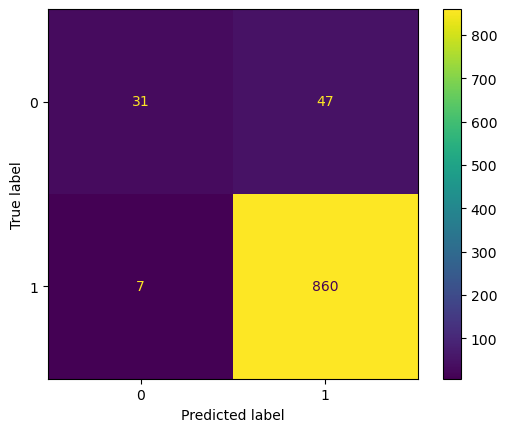

In [59]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [60]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())


Accuracy : 0.9328486219662692
Standard Variance : 0.008326794011401696


Applying grid search to get the optimal parameters on random forest

In [61]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [62]:
from sklearn.model_selection import StratifiedKFold

In [63]:
cv_object=StratifiedKFold(n_splits=2)

grid_search=GridSearchCV(estimator=model_rf,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(X_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [64]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'min_samples_split': 12,
 'n_estimators': 300}

In [65]:
grid_search.best_score_

np.float64(0.9224137931034483)

In [66]:
grid_search.best_estimator_


RandomForestClassifier(max_depth=80, min_samples_split=12, n_estimators=300)

**XgBoost**

In [67]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [68]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9718693284936479
Testing Accuracy : 0.9333333333333333


In [69]:
y_preds = model_xgb.predict(X_test)

In [70]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


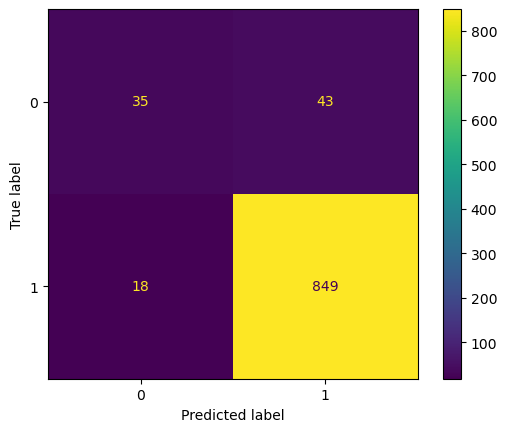

In [71]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [72]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))